In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import jax
import jax.numpy as jnp
from jax import grad
import time

Cost J: tensor(96.0561, dtype=torch.float64, grad_fn=<SumBackward0>)
Gradient dJ/dX0: tensor([ -4.1013, -20.6547,  11.2972,   6.2742], dtype=torch.float64)
Elapsed time: 0.5999765396118164 seconds


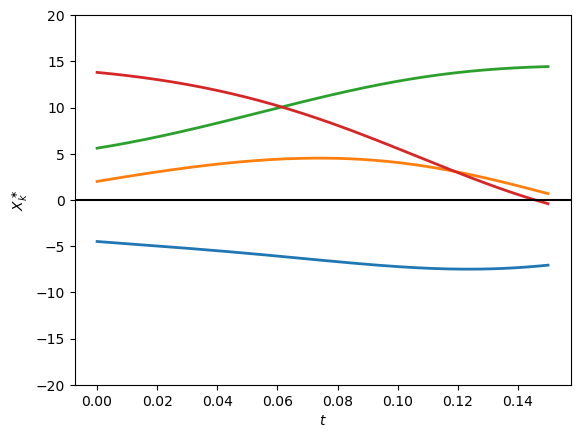

In [2]:
class Lorenz96:
    def __init__(self, N_t, dt, K, F, X0):
        # Model set-up parameters
        self.N_t = N_t
        self.dt = dt
        self.K = K
        self.F = F

        # Model control parameters
        self.X0 = torch.tensor(X0, dtype=torch.float64, requires_grad=True)

        # Variables
        self.X = torch.zeros(K, dtype=torch.float64)
        self.dX = torch.zeros(K, dtype=torch.float64)
        self.dXm1 = torch.zeros(K, dtype=torch.float64)
        self.dXm2 = torch.zeros(K, dtype=torch.float64)

        # Data in time array
        self.X_array = torch.zeros((K, N_t + 1), dtype=torch.float64)

        # Set initial conditions
        self.X = self.X0.clone()
        self.X_array[:, 0] = self.X0

def dXrhs(k, X, F):
    dXk = -X[k - 1] * (X[k - 2] - X[(k + 1) % len(X)]) - X[k] + F
    return dXk

def euler_step(dt, K, F, X, dX, dXm1, dXm2):
    # Compute derivatives
    dX[0] = - X[K - 1] * (X[K - 2] - X[1]) - X[0] + F
    dX[1] = - X[0] * (X[K - 1] - X[2]) - X[1] + F
    dX[K - 1] = - X[K - 2] * (X[K - 3] - X[0]) - X[K - 1] + F

    # Update X
    X[0] += dt * dX[0]
    X[1] += dt * dX[1]
    X[K - 1] += dt * dX[K - 1]
    for k in range(2, K - 1):
        dX[k] = dXrhs(k, X, F)
        X[k] += dt * dX[k]

    # Update dXs
    dXm1[:] = dX
    dXm2[:] = dXm1

    return X, dX, dXm1, dXm2

def adams_bashforth3(x, dt, dx, dxm1, dxm2):
    return x + dt * ((23 / 12) * dx - (16 / 12) * dxm1 + (5 / 12) * dxm2)

def ab3_step(dt, K, F, X, dX, dXm1, dXm2):
    # Compute derivatives
    dX[0] = - X[K - 1] * (X[K - 2] - X[1]) - X[0] + F
    dX[1] = - X[0] * (X[K - 1] - X[2]) - X[1] + F
    dX[K - 1] = - X[K - 2] * (X[K - 3] - X[0]) - X[K - 1] + F

    # Update X
    X[0] = adams_bashforth3(X[0], dt, dX[0], dXm1[0], dXm2[0])
    X[1] = adams_bashforth3(X[1], dt, dX[1], dXm1[1], dXm2[1])
    X[K - 1] = adams_bashforth3(X[K - 1], dt, dX[K - 1], dXm1[K - 1], dXm2[K - 1])
    for k in range(2, K - 1):
        dX[k] = dXrhs(k, X, F)
        X[k] = adams_bashforth3(X[k], dt, dX[k], dXm1[k], dXm2[k])

    # Update dXs
    dXm1[:] = dX
    dXm2[:] = dXm1

    return X, dX, dXm1, dXm2

def forward_model(ms):
    for step in range(2):
        euler_step(ms.dt, ms.K, ms.F, ms.X, ms.dX, ms.dXm1, ms.dXm2)
        ms.X_array[:, step + 1] = ms.X

    for step in range(2, ms.N_t):
        ab3_step(ms.dt, ms.K, ms.F, ms.X, ms.dX, ms.dXm1, ms.dXm2)
        ms.X_array[:, step + 1] = ms.X

class Cost:
    def __init__(self, N_t, dt, K, F, XFO, X0):
        # Model set-up parameters
        self.N_t = N_t
        self.dt = dt
        self.K = K
        self.F = F

        # Model observation
        self.XFO = torch.tensor(XFO, dtype=torch.float64)

        # Model control parameters
        self.X0 = torch.tensor(X0, dtype=torch.float64, requires_grad=True)

        # Variables
        self.X = torch.zeros(K, dtype=torch.float64)
        self.dX = torch.zeros(K, dtype=torch.float64)
        self.dXm1 = torch.zeros(K, dtype=torch.float64)
        self.dXm2 = torch.zeros(K, dtype=torch.float64)

        # Data in time array
        self.X_array = torch.zeros((K, N_t + 1), dtype=torch.float64)

        # Objective Function
        self.J0 = 0.0

        # Set initial conditions
        self.X = self.X0.clone()
        self.X_array[:, 0] = self.X0

def J(cost):
    forward_model(cost)

    X = cost.X
    J0 = torch.sum((X - cost.XFO) ** 2)
    return J0

start_time = time.time()

N_t = 150
dt = 0.001
K = 4
F = 20.0

XFO = [x + 0.1 for x in [2.32, 2.25, 15.48, -1.96]]
X0 = [-4.5, 2.0, 5.6, 13.8]

# Initialize cost model
cost = Cost(N_t, dt, K, F, XFO, X0)

# Compute the cost function and its gradient with respect to X0
J_val = J(cost)
J_val.backward()  # Computes dJ/dX0

print("Cost J:", J_val)
# Access the gradient
print("Gradient dJ/dX0:", cost.X0.grad)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# Model parameters
X0 = [-4.5, 2.0, 5.6, 13.8]
ts = torch.arange(0, (N_t + 1) * dt, dt)

# Initialize model
L96 = Lorenz96(N_t, dt, K, F, X0)

# Run forward model
forward_model(L96)

# Plot
plt.plot(ts.detach().numpy(), L96.X_array.T.detach().numpy(), lw=2)
plt.xlabel(r'$t$')
plt.ylabel(r'$X_k^\ast$')
plt.ylim([-20, 20])
plt.axhline(0, color='black')
plt.show()

Cost J: 96.0560924135984
Gradient dJ/dX0: [ -4.10130856 -20.6547281   11.29721012   6.27416351]
Elapsed time: 17.24829077720642 seconds


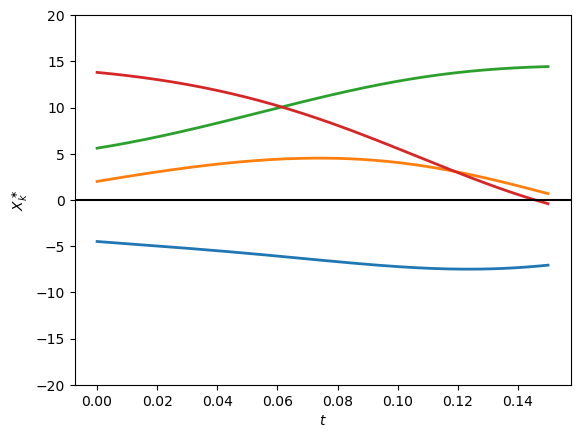

In [4]:
class Lorenz96:
    def __init__(self, N_t, dt, K, F, X0):
        # Model set-up parameters
        self.N_t = N_t
        self.dt = dt
        self.K = K
        self.F = F

        # Model control parameters
        self.X0 = jnp.array(X0, dtype=jnp.float64)

        # Variables
        self.X = jnp.zeros(K, dtype=jnp.float64)
        self.dX = jnp.zeros(K, dtype=jnp.float64)
        self.dXm1 = jnp.zeros(K, dtype=jnp.float64)
        self.dXm2 = jnp.zeros(K, dtype=jnp.float64)

        # Data in time array
        self.X_array = jnp.zeros((K, N_t + 1), dtype=jnp.float64)

        # Set initial conditions
        self.X = self.X0.copy()
        self.X_array = self.X_array.at[:, 0].set(self.X0)

def dXrhs(k, X, F):
    dXk = -X[k - 1] * (X[k - 2] - X[(k + 1) % len(X)]) - X[k] + F
    return dXk

def euler_step(dt, K, F, X, dX, dXm1, dXm2):
    # Compute derivatives
    dX = dX.at[0].set(- X[K - 1] * (X[K - 2] - X[1]) - X[0] + F)
    dX = dX.at[1].set(- X[0] * (X[K - 1] - X[2]) - X[1] + F)
    dX = dX.at[K - 1].set(- X[K - 2] * (X[K - 3] - X[0]) - X[K - 1] + F)

    # Update X
    X = X.at[0].add(dt * dX[0])
    X = X.at[1].add(dt * dX[1])
    X = X.at[K - 1].add(dt * dX[K - 1])
    for k in range(2, K - 1):
        dX = dX.at[k].set(dXrhs(k, X, F))
        X = X.at[k].add(dt * dX[k])

    # Update dXs
    dXm1 = dX
    dXm2 = dXm1

    return X, dX, dXm1, dXm2

def adams_bashforth3(x, dt, dx, dxm1, dxm2):
    return x + dt * ((23 / 12) * dx - (16 / 12) * dxm1 + (5 / 12) * dxm2)

def ab3_step(dt, K, F, X, dX, dXm1, dXm2):
    # Compute derivatives
    dX = dX.at[0].set(- X[K - 1] * (X[K - 2] - X[1]) - X[0] + F)
    dX = dX.at[1].set(- X[0] * (X[K - 1] - X[2]) - X[1] + F)
    dX = dX.at[K - 1].set(- X[K - 2] * (X[K - 3] - X[0]) - X[K - 1] + F)

    # Update X
    X = X.at[0].set(adams_bashforth3(X[0], dt, dX[0], dXm1[0], dXm2[0]))
    X = X.at[1].set(adams_bashforth3(X[1], dt, dX[1], dXm1[1], dXm2[1]))
    X = X.at[K - 1].set(adams_bashforth3(X[K - 1], dt, dX[K - 1], dXm1[K - 1], dXm2[K - 1]))
    for k in range(2, K - 1):
        dX = dX.at[k].set(dXrhs(k, X, F))
        X = X.at[k].set(adams_bashforth3(X[k], dt, dX[k], dXm1[k], dXm2[k]))

    # Update dXs
    dXm1 = dX
    dXm2 = dXm1

    return X, dX, dXm1, dXm2

def forward_model(N_t, dt, K, F, X0):
    # Initialize the Lorenz96 model
    model = Lorenz96(N_t, dt, K, F, X0)
    
    for step in range(2):
        model.X, model.dX, model.dXm1, model.dXm2 = euler_step(model.dt, model.K, model.F, model.X, model.dX, model.dXm1, model.dXm2)
        model.X_array = model.X_array.at[:, step + 1].set(model.X)

    for step in range(2, model.N_t):
        model.X, model.dX, model.dXm1, model.dXm2 = ab3_step(model.dt, model.K, model.F, model.X, model.dX, model.dXm1, model.dXm2)
        model.X_array = model.X_array.at[:, step + 1].set(model.X)
    
    return model.X_array

def J(X0, XFO, N_t, dt, K, F):
    # Run the forward model
    X_array = forward_model(N_t, dt, K, F, X0)
    
    # Take the final time step for comparison to XFO
    X_final = X_array[:, -1]
    
    # Compute the cost (sum of squared errors)
    J0 = jnp.sum((X_final - XFO) ** 2)
    return J0

start_time = time.time()

# Set default precision to float64
jax.config.update("jax_enable_x64", True)

# Model parameters
N_t = 150
dt = 0.001
K = 4
F = 20.0

XFO = jnp.array([2.32, 2.25, 15.48, -1.96]) + 0.1
X0 = jnp.array([-4.5, 2.0, 5.6, 13.8])

# Compute the cost function and its gradient with respect to X0 using JAX
J_grad = grad(J)(X0, XFO, N_t, dt, K, F)

print("Cost J:", J(X0, XFO, N_t, dt, K, F))
print("Gradient dJ/dX0:", J_grad)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# Model parameters for plotting
X0_plot = jnp.array([-4.5, 2.0, 5.6, 13.8])
ts = jnp.arange(0, (N_t + 1) * dt, dt)

# Run forward model for plotting
L96_X_array = forward_model(N_t, dt, K, F, X0_plot)

# Plot the results
plt.plot(ts, L96_X_array.T, lw=2)
plt.xlabel(r'$t$')
plt.ylabel(r'$X_k^\ast$')
plt.ylim([-20, 20])
plt.axhline(0, color='black')
plt.show()